#  Part 2: Synthetic Data Generation and Training Workflow with Warehouse Sim Ready Assets

This notebook is the second part of the SDG and Training Workflow. Here, we will be focusing on training an Object Detection Network with TAO toolkit

A high level overview of the steps:
* Pulling TAO Docker Container
* Training Detectnet_v2 model with Data generated in Part 1
* Visualizing Model Performance on Sample Real World Data


### Table of Contents

This notebook shows an example usecase of Object Detection using DetectNet_v2 in the Train Adapt Optimize (TAO) Toolkit. We will train the model with Synthetic Data generated from Omniverse Replicator.

1. [Set up TAO via Docker container](#head-1)
2. [Download Pretrained model](#head-2)
3. [Convert Dataset to TFRecords for TAO](#head-3)
4. [Provide training specification](#head-4)
5. [Run TAO training](#head-5)
6. [Evaluate trained model](#head-6)
7. [Visualize Model Predictions on Real World Data](#head-7)
8. [Next Steps](#head-8)

## 1. Set up TAO via Docker Container <a class="anchor" id="head-1"></a>

* We will follow the [instructions](https://docs.nvidia.com/tao/tao-toolkit/text/tao_toolkit_quick_start_guide.html#running-tao-toolkit) for using TAO toolkit. Make sure that the pre-requisite steps are completed (installing `docker`, `nvidia container toolkit` and `docker login nvcr.io`)

* The docker container being used for training will be pulled in the cells below, make sure you have completed the pre-requisite steps and `docker login nvcr.io` to allow pulling of the container from NGC


In [ ]:
import os
%env DOCKER_REGISTRY=nvcr.io
%env DOCKER_NAME=nvidia/tao/tao-toolkit
%env DOCKER_TAG=4.0.0-tf1.15.5 ## for TensorFlow docker

%env DOCKER_CONTAINER=nvcr.io/nvidia/tao/tao-toolkit:4.0.0-tf1.15.5


## 2. Download Pretrained Model <a class="anchor" id="head-2"></a>

* We will use the `detectnet_v2` Object Detection model with a `resnet18` backbone
* Make sure the `LOCAL_PROJECT_DIR` environment variable has the path of this cloned repository in the cell below


In [ ]:
# os.environ["LOCAL_PROJECT_DIR"] = "<LOCAL_PATH_OF_CLONED_REPO>"
os.environ["LOCAL_PROJECT_DIR"] = os.path.dirname(os.path.dirname(os.getcwd())) # This is the location of the root of the cloned repo
print(os.environ["LOCAL_PROJECT_DIR"])

In [ ]:
!wget --quiet --show-progress --progress=bar:force:noscroll --auth-no-challenge --no-check-certificate \
        https://api.ngc.nvidia.com/v2/models/nvidia/tao/pretrained_detectnet_v2/versions/resnet18/files/resnet18.hdf5 \
        -P  $LOCAL_PROJECT_DIR/cloud/training/tao/pretrained_model/

## 3. Convert Dataset to TFRecords for TAO <a class="anchor" id="head-3"></a>

* The `Detectnet_v2` model in TAO expects data in the form of TFRecords for training. 
* We can convert the KITTI Format Dataset generated from Part 1 with the `detectnet_v2 dataset_convert` tool provided with TAO toolkit


In [ ]:
print("Converting Tfrecords for palletjack warehouse distractors dataset")

!mkdir -p $LOCAL_PROJECT_DIR/cloud/training/tao/tfrecords/distractors_warehouse && rm -rf $LOCAL_PROJECT_DIR/cloud/training/tao/tfrecords/distractors_warehouse/*

!docker run -it --rm --gpus all -v $LOCAL_PROJECT_DIR:/workspace/tao-experiments $DOCKER_CONTAINER \
                   detectnet_v2 dataset_convert \
                  -d /workspace/tao-experiments/cloud/training/tao/specs/tfrecords/distractors_warehouse.txt \
                  -o /workspace/tao-experiments/cloud/training/tao/tfrecords/distractors_warehouse/

In [ ]:
print("Converting Tfrecords for palletjack with additional distractors")

!mkdir -p $LOCAL_PROJECT_DIR/cloud/training/tao/tfrecords/distractors_additional && rm -rf $LOCAL_PROJECT_DIR/cloud/training/tao/tfrecords/distractors_additional/*

!docker run -it --rm --gpus all -v $LOCAL_PROJECT_DIR:/workspace/tao-experiments $DOCKER_CONTAINER \
                   detectnet_v2 dataset_convert \
                  -d /workspace/tao-experiments/cloud/training/tao/specs/tfrecords/distractors_additional.txt \
                  -o /workspace/tao-experiments/cloud/training/tao/tfrecords/distractors_additional/

In [ ]:
print("Converting Tfrecords for kitti trainval dataset")
# !mkdir -p $LOCAL_DATA_DIR/tfrecords/july/distractors_palletjack_warehouse && rm -rf $LOCAL_DATA_DIR/tfrecords/july/distractors_palletjack_warehouse/*
!mkdir -p $LOCAL_PROJECT_DIR/cloud/training/tao/tfrecords/no_distractors && rm -rf $LOCAL_PROJECT_DIR/cloud/training/tao/tfrecords/no_distractors/*

!docker run -it --rm --gpus all -v $LOCAL_PROJECT_DIR:/workspace/tao-experiments $DOCKER_CONTAINER \
                   detectnet_v2 dataset_convert \
                  -d /workspace/tao-experiments/cloud/training/tao/specs/tfrecords/no_distractors.txt \
                  -o /workspace/tao-experiments/cloud/training/tao/tfrecords/no_distractors/

## 4. Provide Training Specification File <a class="anchor" id="head-4"></a>

* The spec file for training with TAO is provided under `$LOCAL_PROJECT_DIR/specs/training/resnet18_distractors.txt`
* The tfrecords and the synthetic data generated in the previous steps are provided under the `dataset_config` parameter of the file
* Other parameters like `augmentation_config`, `model_config`, `postprocessing_config` can be adjusted. Refer to [this](https://docs.nvidia.com/tao/tao-toolkit/text/object_detection/detectnet_v2.html) for a detailed guideline on adjusting the parameters in the spec file
* For training our model to detect `palletjacks` this `spec` file provided can be used directly


In [ ]:
!cat $LOCAL_PROJECT_DIR/cloud/training/tao/specs/training/resnet18_distractors.txt

### Hyperparameters can be set in the `spec` file. Adjust batch size parameter depending on the VRAM of your GPU 

* You can increase the number of epochs, the number of false positives in real world images keeps decreasing (mAP does not change much after ~250 epochs and usually results in the best trained model for the given dataset)

## 5. Run TAO Training <a class="anchor" id="head-5"></a>

* The `$LOCAL_PROJECT_DIR` will be mounted to the TAO docker for training, this contains all the data, pretrained model and spec files (training and inference) needed

#### Ensure that no `_warning.json` file exists in the `$LOCAL_PROJECT_DIR/cloud/training/tao/tfrecords` sub-folders (`distractors_additional`, `ditractors_warehouse` and `no_distractors`)
* Delete the `_warning.json` files before beginning training
* TAO training won't begin if the structure of the `tfrecords` folder directories is not as expected 

In [ ]:
# Setting up env variables for cleaner command line commands.
%env KEY=tlt_encode
%env NUM_GPUS=1

* TAO Training can be stopped and resumed (`checkpoint_interval` parameter specified in the `spec` file)
* Tensorboard visualization can be used with TAO [instructions](https://docs.nvidia.com/tao/tao-toolkit/text/tensorboard_visualization.html#visualizing-using-tensorboard). 
* The `$RESULTS_DIR` parameter is the folder where the `$LOCAL_PROJECT_DIR/cloud/training/tao/detectnet_v2/resnet18_palletjack` folder which is specified with the `-i` flag in the command below

In [ ]:
!docker run -it --rm --gpus all -v $LOCAL_PROJECT_DIR:/workspace/tao-experiments $DOCKER_CONTAINER \
            detectnet_v2 train -e /workspace/tao-experiments/cloud/training/tao/specs/training/resnet18_distractors.txt \
            -r /workspace/tao-experiments/cloud/training/tao/detectnet_v2/resnet18_palletjack -k $KEY --gpus $NUM_GPUS

## 6. Evaluate Trained Model <a class="anchor" id="head-6"></a>

* While generating the `tfrecords` part of the total data generated was kept as a validation set (14% of total data)
* We will run our model evaluation on this data to obtain metrics

In [ ]:
!docker run -it --rm --gpus all -v $LOCAL_PROJECT_DIR:/workspace/tao-experiments $DOCKER_CONTAINER \
            detectnet_v2 evaluate -e /workspace/tao-experiments/cloud/training/tao/specs/training/resnet18_distractors.txt \
            -m /workspace/tao-experiments/cloud/training/tao/detectnet_v2/resnet18_palletjack/weights/model.tlt \
            -k $KEY --gpus $NUM_GPUS

## 7. Visualize Model Performance on Real World Data <a class="anchor" id="head-7"></a>

* Lets visualize the model predictions on a few sample real world images next
* We will use palletjack images in a warehouse from the `LOCO` dataset to understand if the model is capable of performing real world detections
* Additional images can be placed under the `loco_palletjacks` folder of this project. The input folder is specified with the `-i` flag in the command below 

In [ ]:
!docker run -it --rm --gpus all -v $LOCAL_PROJECT_DIR:/workspace/tao-experiments $DOCKER_CONTAINER \
                            detectnet_v2 inference -e /workspace/tao-experiments/cloud/training/tao/specs/inference/new_inference_specs.txt \
                            -o /workspace/tao-experiments/cloud/training/tao/detectnet_v2/resnet18_palletjack/test_loco \
                            -i /workspace/tao-experiments/images/loco_palletjacks \
                            -k $KEY

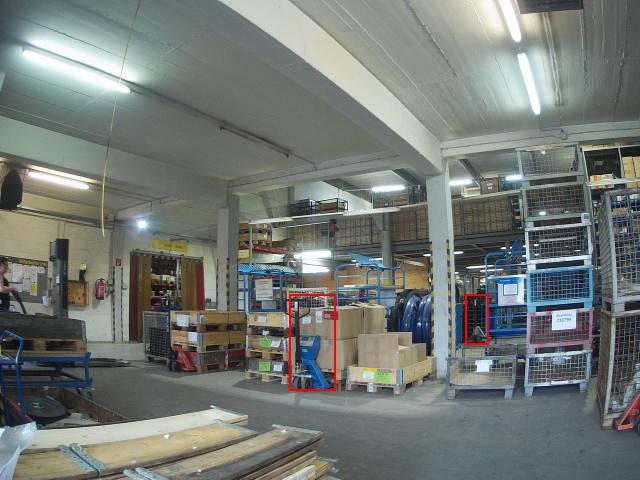

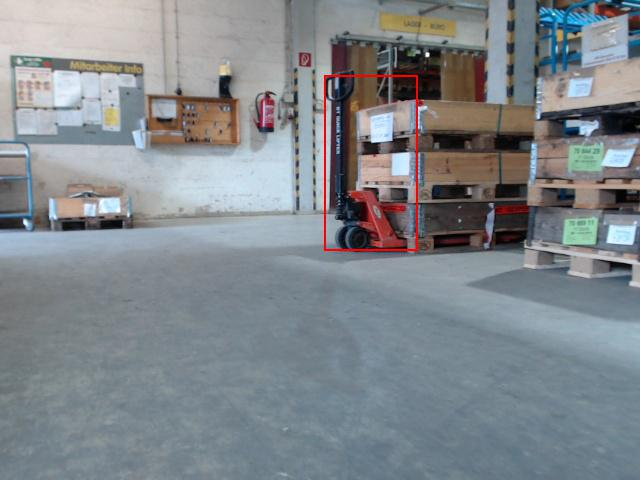

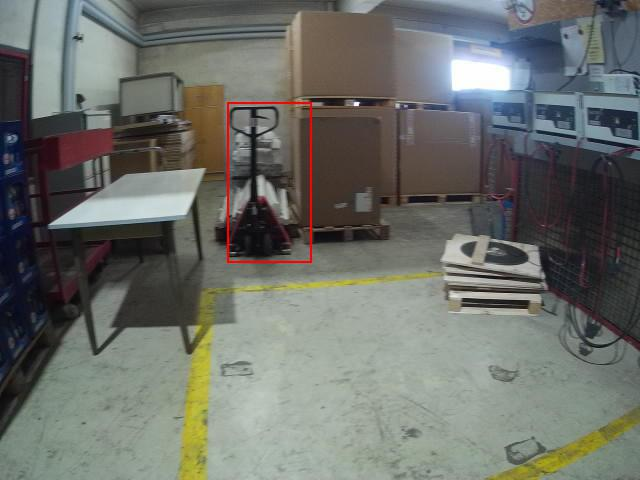

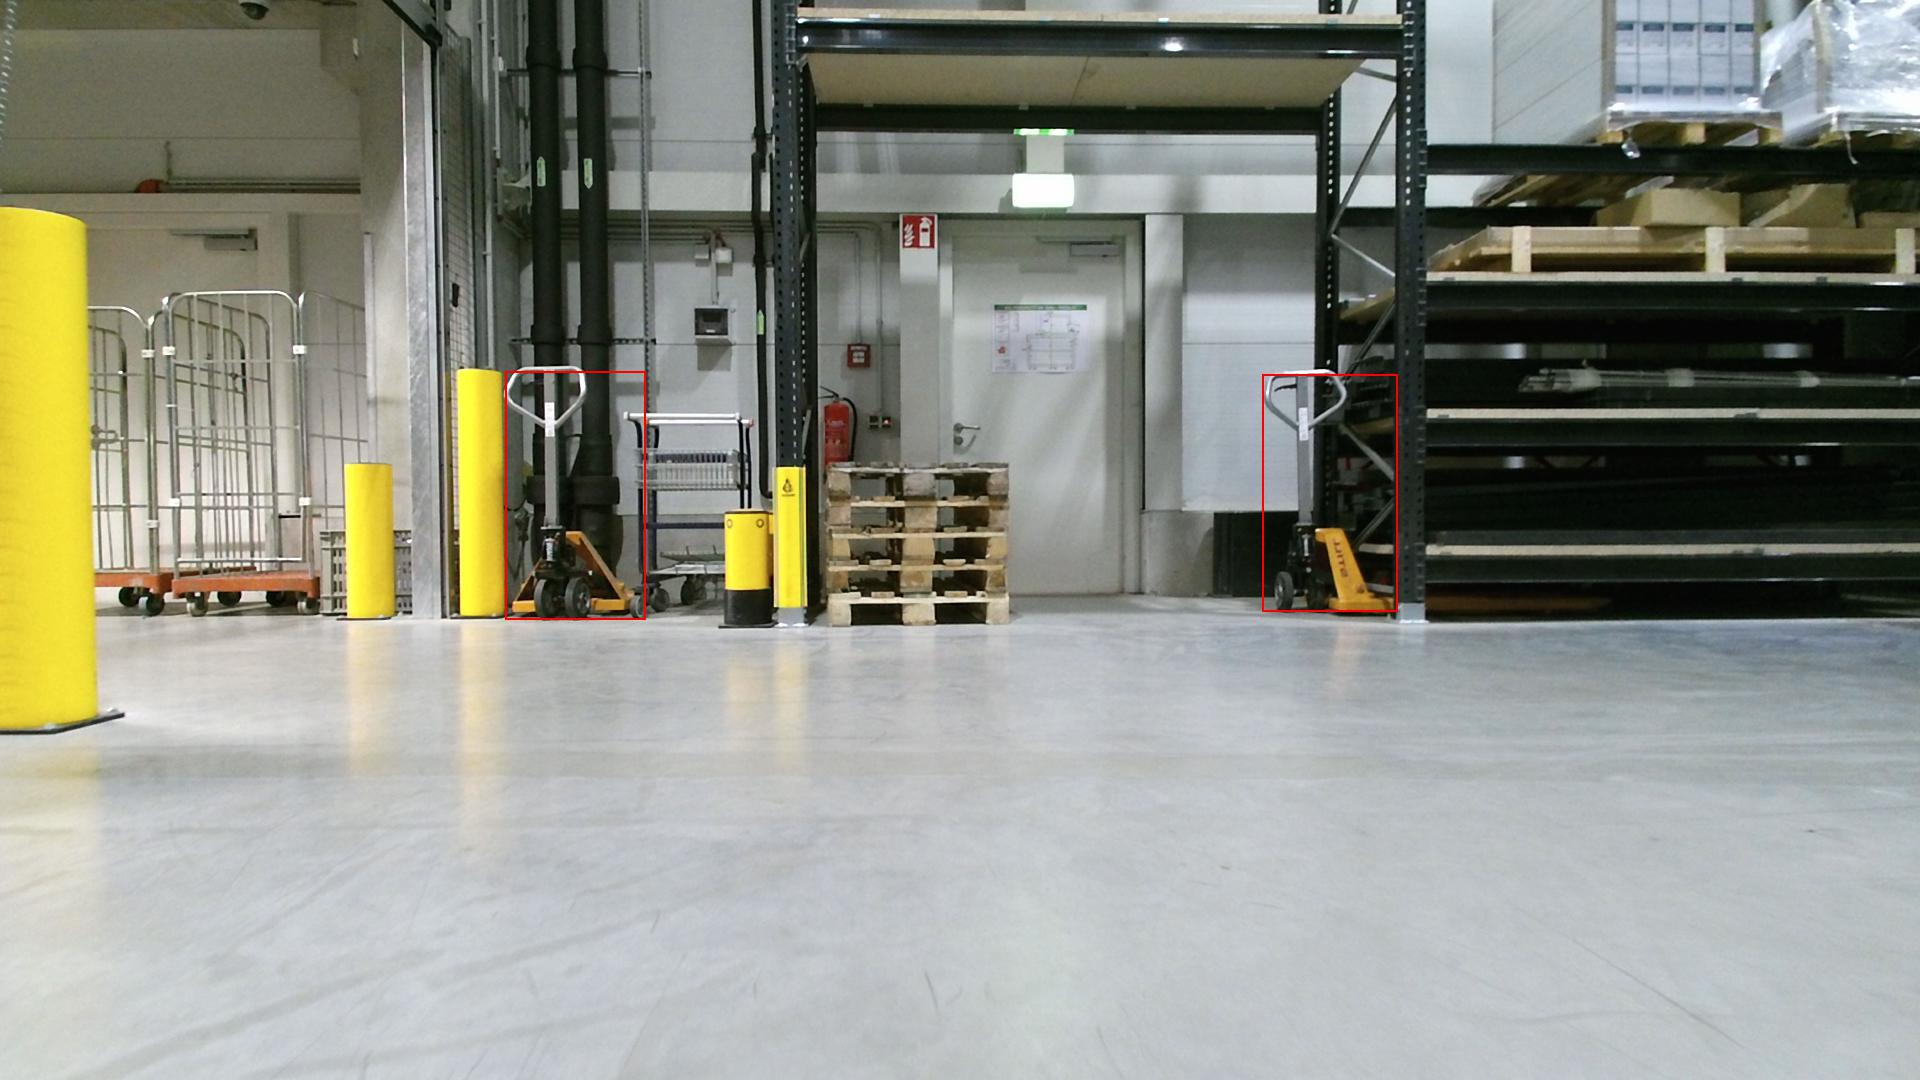

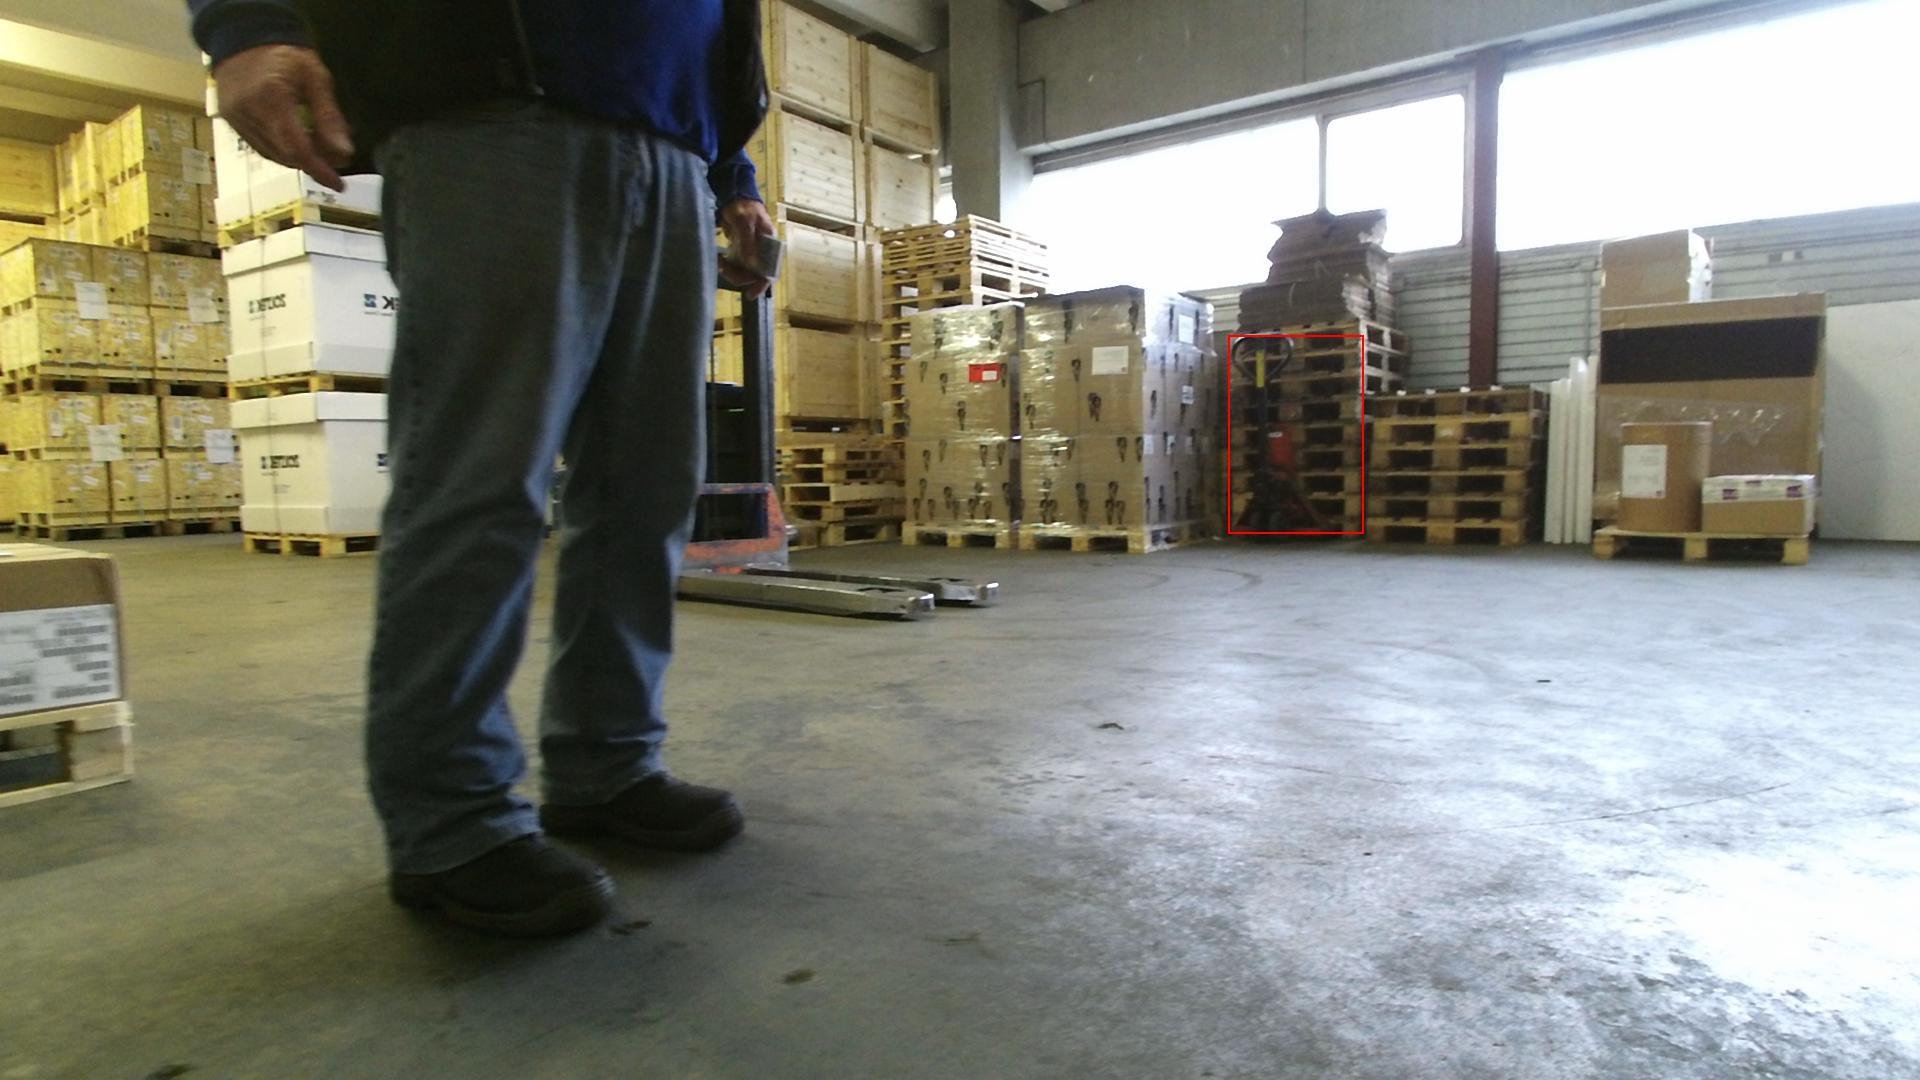

In [23]:
from IPython.display import Image 

results_dir = os.path.join(os.environ["LOCAL_PROJECT_DIR"], "cloud/training/tao/detectnet_v2/resnet18_palletjack/test_loco/images_annotated")
# pil_img = Image(filename=os.path.join(os.getenv("LOCAL_PROJECT_DIR"), 'detecnet_v2/july_resnet18_trials/new_pellet_distractors_10k/test_loco/images_annotated/1564562568.298206.jpg'))
                           
image_names = ["1564562568.298206.jpg", "1564562628.517229.jpg", "1564562843.0618184.jpg", "593768,3659.jpg", "516447400,977.jpg"] 
                           
images = [Image(filename = os.path.join(results_dir, image_name)) for image_name in image_names]

display(*images)

## 8. Next Steps <a class="anchor" id="head-8"></a>

#### Generating Synthetic Data for your use case:

* Make changes in the Domain Randomization under the Synthetic Data Generation script (`palletjack_sdg/standalone_palletjack_sdg.py`
* Add additional objects of interest in the scene (similar to how `palletjacks` are added, you can add `forklifts`, `ladders` etc.) to generate data
* Use [different](https://docs.nvidia.com/tao/tao-toolkit/text/tao_toolkit_quick_start_guide.html#downloading-the-models) models for training with TAO (for object detection, you can use `YOLO`, `SSD`, `EfficientDet`) 
* Replicator provides Semantic Segmentation, Instance Segmentation, Depth and various other ground truth annotations along with RGB. You can also write your own ground truth annotator (eg: Pose Estimation: Refer to [sample](https://docs.omniverse.nvidia.com/isaacsim/latest/tutorial_replicator_offline_pose_estimation.html). These can be used for training a model of your own framework and choice
* Exploring the option of using `Synthetic + Real` data for training a network. Can be particularly useful for generating more data around particular corner cases


#### Deploying Trained Models:

* After obtaining satisfactory results with the training process, you can further optimize your model for deployment with the help of Pruning and QAT.
* TAO models can directly be deployed on Jetson with Isaac ROS or Deepstream which ensures your end-to-end pipeline being optimized (data acquisition -> model inference -> results)